In [1]:
#Owen Henry, Matt Peters, Zach Eberle
#Group 10
#Publicly Listed Companies and the Presence of H1B Workers
# Imports
import yfinance as yf
import pandas as pd
import json
from io import StringIO
import re
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import time

In [2]:
# Gets a list of all listed companies from SEC's EDGAR database
#"https://www.sec.gov/files/company_tickers.json"

with open('data/company_tickers.json', 'r') as f:
    data = json.load(f)

In [3]:
### Clean and Aggregate H1B Visa Data by Company Ticker ###

def read_tsv(file_path):
    #Reads a TSV file with UTF-8 encoding
    #Had to convert econding to UTF8 via notepad++
    with open(file_path, "r", encoding="utf-8") as f:
        return pd.read_csv(StringIO(f.read()), delimiter="\t", low_memory=False)

# List of common suffixes and irrelevant words to strip from company names
remove_terms = [
    "INCORPORATED", "INC", "CORPORATION", "CORP", "NA", "N A", "ENTERTAINMENT",
    "CONSULTING", "FINANCIAL", "FINANCIALS", "LOGISTICS", "INDUSTRIES", "MANAGEMENT",
    "LTD", "LIMITED", "LLC", "LLP", "PLC", "GROUP", "GRP", "GR", "HOLDINGS", "COMPANY",
    "CO", "LP", "LL", "PARTNERSHIP", "TECHNOLOGIES", "SYSTEMS", "GLOBAL", "ENTERPRISES",
    "SERVICES", "COM", "COMMUNICATIONS", "SOLUTIONS", "INVESTMENT", "PHARMACEUTICALS", 
    "INTERNATIONAL", "INTL", "WORLDWIDE", "THE", "USA", "US", "U S A" "REFRESHMENTS", "DATA",
    "TELEMATICS", "RESOURCES", "MEDIA", "SVCS", "SUPPORT", "TECH", "OPS", "PLATFORM",
    "PLATFORMS", "CORPORATE", "WEB", "CHEMICAL", "MOTORS", "MOTOR", "ASSOCIATES", "STORES",
    "DEPARTMENT", "DEPT", "AMERICAS", "ENGINEERING", "SOLNS", "TECHNOLOGY", "INFOTECH"
]
remove_terms_pattern = re.compile(r'\b(' + '|'.join(remove_terms) + r')\b')
    
def clean_company_name(name):
    name = str(name).upper()
    name = re.sub(r'\s+', ' ', name).strip()
    name = remove_terms_pattern.sub('', name)
    name = re.sub(r'/[^/]+/', ' ', name)
    name = re.sub(r"[.\,'+()*^#@!]", "", name)
    name = name.replace('-', ' ')
    name = name.replace('&', 'AND')
    name = re.sub(r'\s+', ' ', name).strip()
    return name

# Create a mapping from cleaned company names to stock tickers
company_mapping = {clean_company_name(company['title']): company['ticker'] for company in data.values()}
company_mapping.update({
    "BOEING": "BA", "ATANDT": "T", "FACEBOOK": "META", "GOOGLE": "GOOG", "SNAPCHAT": "SNAP", "KRAFT FOODS": "MDLZ",
    "SQUARE": "SQ", "PRICELINE": "BKNG", "HEWLETT-PACKARD": "HPQ", "TATA CONSULTANCY": "TCS", "MAHINDRA": "TECHM",
    "HCL AMERICA": "HCLTECH.NS", "CAPGEMINI": "CGM", "CAPGEMINI AMERICA": "CGM", "CAPGEMINI U S": "CGM", "IBM": "IBM",
    "CAPITAL ONE": "COF", "CAPITAL ONE II": "COF", "WAL MART": "WMT", "LARSEN AND TOUBRO": "LT", "QUALCOMM": "QCOM", 
    "JPMORGAN CHASE": "JPM", "JPMORGAN CHASE AND": "JPM", "FORD": "F"
})

visa_files = {"h1b": ['data/visas/h1b_2016_2009.csv', 'data/visas/h1b_2019_2017.csv', 'data/visas/h1b_2024_2020.csv']}

# Read and clean all visa data
df_visas = []
for visa_type, files in visa_files.items():
    df_list = [read_tsv(file) for file in files]
    df = pd.concat(df_list, axis=0)
    df["employer"] = df["Employer (Petitioner) Name"].apply(clean_company_name)
    df["type"] = visa_type
    df_visas.append(df)

df_visas_combined = pd.concat(df_visas)
df_visas_matched = df_visas_combined.copy()

# Match employer names to their stock tickers
df_visas_matched["ticker"] = df_visas_matched["employer"].map(company_mapping)
df_visas_matched = df_visas_matched[df_visas_matched["ticker"].notna()]

drop_cols = ['Line by line', 'Employer (Petitioner) Name', 'Initial Denial', 'Continuing Denial']
df_visas_clean = df_visas_matched.drop(drop_cols, axis=1).copy()
df_visas_clean.columns = df_visas_clean.columns.str.strip()

# Clean and convert selected columns to integer type
int_columns = ["Fiscal Year", "Tax ID", "Petitioner Zip Code", "Initial Approval", "Continuing Approval"]
for col in int_columns:
    df_visas_clean[col] = df_visas_clean[col].astype(str).str.replace(",", "", regex=False).str.strip()
    df_visas_clean[col] = pd.to_numeric(df_visas_clean[col], errors="coerce").astype("Int64")

def most_common(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    else:
        return None

# Aggregate visa data by Fiscal Year and Company Ticker
final_sum = df_visas_clean.groupby(["Fiscal Year", "ticker"], as_index=False).agg({
    "employer": most_common,
    "Tax ID": most_common,
    "Industry (NAICS) Code": most_common,
    "Petitioner City": most_common,
    "Petitioner State": most_common,
    "Petitioner Zip Code": most_common,
    "Initial Approval": "sum",
    "Continuing Approval": "sum",
    "type": "first"
})

h1b_df = final_sum.copy()

In [4]:
# This function is adapted from ohenry608's github/finance repo
def fetch_stock_data(tickers):
    all_data = {}
    print('Downloading yfinance historical price data 2020/01/01 to 2025/03/16')
    num_downloaded = 0
    for ticker in tickers:
        try:
            data = yf.download(ticker, start="2020-01-01", end="2025-03-16", progress = False)
            all_data[ticker] = data
            num_downloaded +=1
            time.sleep(2.2)  # Sleep for 2 seconds between requests to avoid being blocked
        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.2)

    print('Successfully downloaded ' + str(num_downloaded/len(tickers)))
    #Save a csv for offline work
    sp500_data = pd.concat(all_data, axis=1)
    sp500_data.to_csv("sp500_data.csv")
    
    print("S&P 500 historical data saved to sp500_data.csv")
    return sp500_data

#Only run this once on your system
#Make sure NOT to track the sp500_data csv
#sp500csv made for offline work
#fetch_stock_data

In [ ]:
h1b_df['tot_app'] = h1b_df['Initial Approval'] + h1b_df['Continuing Approval']
h1b_df.head()

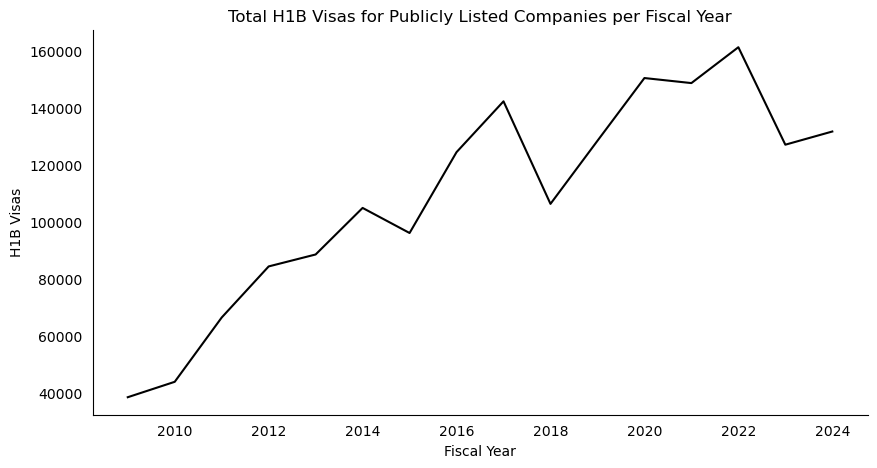

In [7]:
year_sums = h1b_df.groupby('Fiscal Year').sum().loc[:, ['tot_app']].reset_index()
fig, ax = plt.subplots(figsize=(10,5)) 

#Plots a chart of aggregate h1b visas issued for preliminary research
ax.plot('Fiscal Year', 'tot_app' ,data = year_sums, color='black')  
ax.set_ylabel('H1B Visas')
ax.set_xlabel('Fiscal Year')
ax.set_title('Total H1B Visas for Publicly Listed Companies per Fiscal Year')
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()


In [8]:
#Run once to have data locally
#Downloads voo price data from 2008 to 2025
voo_data = yf.download('VOO', start="2008-01-01", end="2025-01-01", progress = False, interval='1wk')
#voo_data.to_csv('data/voo_hist_data.csv')
#voo_data = pd.read_csv('data/voo_hist_data.csv')
voo_data.head()

YF.download() has changed argument auto_adjust default to True


Price           Close       High        Low       Open  Volume
Ticker            VOO        VOO        VOO        VOO     VOO
Date                                                          
2010-09-06  77.804489  78.354885  77.315249  78.354885   35100
2010-09-13  79.012268  79.409773  78.263117  78.706492  211300
2010-09-20  80.143623  80.602291  78.828796  79.302743  113800
2010-09-27  80.486687  81.224532  79.487518  80.686522  142600
2010-10-04  81.993118  82.039232  79.549004  80.901723  496900

In [9]:
voo_data['year'] = voo_data.index.year
yearly_voo = voo_data.groupby('year').mean().droplevel('Ticker', axis=1)

In [10]:
#Calculating percent change metrics for vizualization
yearly_voo['vol_change'] = yearly_voo['Volume'].pct_change()
yearly_voo['open_change'] = yearly_voo['Open'].pct_change()
yearly_voo['close_change'] = yearly_voo['Close'].pct_change()
yearly_voo.head()

Price       Close        High         Low        Open        Volume  \
year                                                                  
2010    83.894039   84.346605   82.488788   83.438501  2.457647e+05   
2011    90.351377   91.944942   88.499466   90.294932  1.089531e+06   
2012   100.639401  101.689033   99.149782  100.294879  1.978665e+06   
2013   123.059823  123.885116  121.346611  122.589879  4.896577e+06   
2014   147.051351  148.269504  145.189702  146.769964  6.308038e+06   

Price  vol_change  open_change  close_change  
year                                          
2010          NaN          NaN           NaN  
2011     3.433227     0.082173      0.076970  
2012     0.816071     0.110748      0.113867  
2013     1.474687     0.222295      0.222780  
2014     0.288255     0.197244      0.194958

In [ ]:
year_sums['chng'] = year_sums['tot_app'].pct_change()
combined = yearly_voo.merge(year_sums, left_on='year', right_on='Fiscal Year')

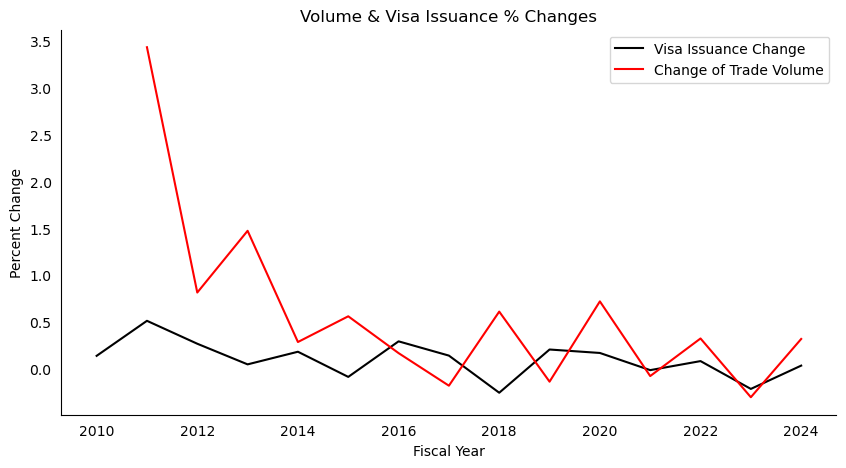

In [13]:

fig, ax = plt.subplots(figsize=(10,5)) 
#Plots visa issuance and trade volume changes
ax.plot('Fiscal Year', 'chng' ,label = "Visa Issuance Change", data = combined, color='black')  
ax.plot('Fiscal Year', 'vol_change' , label = "Change of Trade Volume", data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Volume & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()

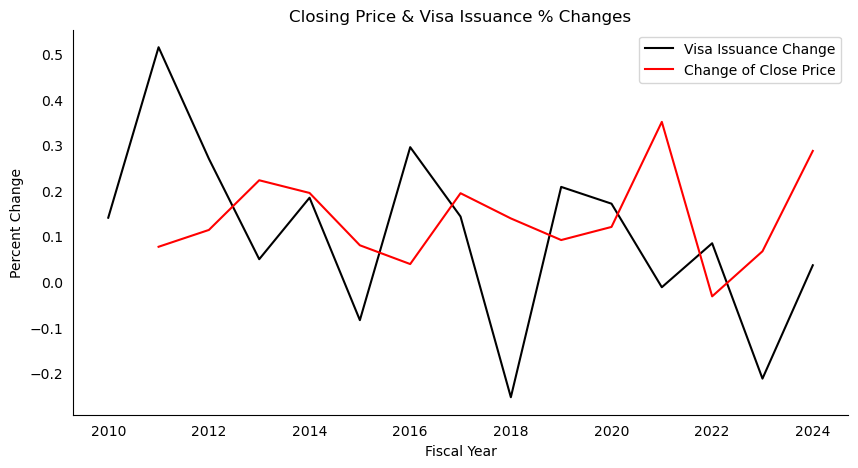

In [14]:

fig, ax = plt.subplots(figsize=(10,5)) 
#Plots voo closing price and visa issuance in percent change
ax.plot('Fiscal Year', 'chng' ,label = "Visa Issuance Change",data = combined, color='black')  
ax.plot('Fiscal Year', 'close_change' ,label = "Change of Close Price",data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Closing Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()

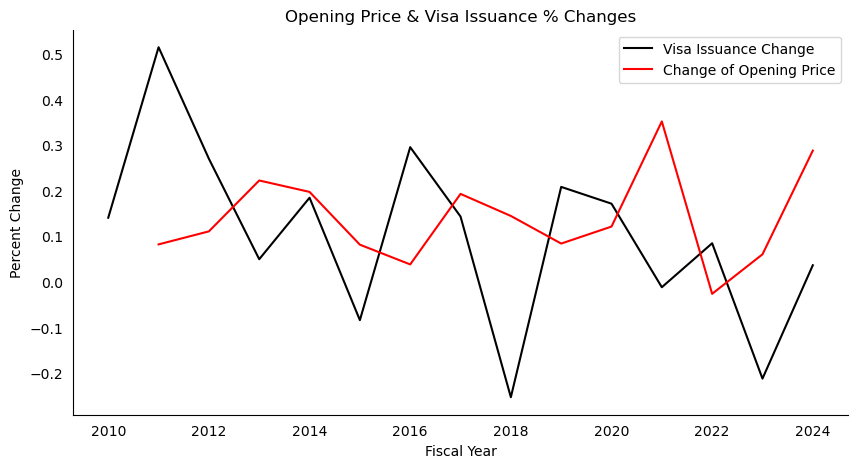

In [15]:

fig, ax = plt.subplots(figsize=(10,5)) 
#Plots VOO opening price and visa issuance percent changes
ax.plot('Fiscal Year', 'chng' ,label = "Visa Issuance Change",data = combined, color='black')  
ax.plot('Fiscal Year', 'open_change' ,label = "Change of Opening Price",data = combined, color='red') 
ax.set_ylabel('Percent Change')
ax.set_xlabel('Fiscal Year')
ax.set_title('Opening Price & Visa Issuance % Changes')
ax.legend()
sns.despine(ax=ax)
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)

plt.show()

In [16]:
#This function is adapted from ohenry608's github/finance repo
def fetch_stock_info(tickers):
    #all_data = {}
    infor = {}
    dict_list = []
    print('Downloading yfinance information on select tickers...')
    for ticker in tickers:
        try:
            infor[ticker] = yf.Ticker(ticker).info
            time.sleep(2.001)  # Sleep for 2 seconds between requests to avoid being blocked

        except Exception as e:
            print(f"Error downloading {ticker}: {e}")
            time.sleep(2.001)
    return pd.DataFrame(infor)

In [17]:
#Only run once, takes a bit of time
#company_info_df = fetch_stock_info(h1b_df['ticker'].unique())
#company_info_df.to_csv('company_info_df.csv')

In [18]:
company_info_df = pd.read_csv('company_info_df.csv').T
company_info_df = company_info_df.rename(columns=company_info_df.iloc[0]).drop(company_info_df.index[0])
company_info_df.head()

address1         city state         zip  \
A     5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
AA             201 Isabella Street   Pittsburgh    PA  15212-5858   
AAL                1 Skyview Drive   Fort Worth    TX       76155   
AAMI          200 Clarendon Street       Boston    MA       02116   
AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

            country           phone           fax                  website  \
A     United States    800 227 9770  866 497 1134  https://www.agilent.com   
AA    United States    412 315 2900           NaN    https://www.alcoa.com   
AAL   United States    682 278 9000           NaN       https://www.aa.com   
AAMI  United States    617-369-7300           NaN     https://www.bsig.com   
AAOI  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                     industry              industryKey  ... fundFamily  \
A      Diagnostics & Research     diagnostics-research  ...        NaN   
AA                   Aluminum                 aluminum  ...        NaN   
AAL                  Airlines                 airlines  ...        NaN   
AAMI         Asset Management         asset-management  ...        NaN   
AAOI  Communication Equipment  communication-equipment  ...        NaN   

     fundInceptionDate legalType threeYearAverageReturn  \
A                  NaN       NaN                    NaN   
AA                 NaN       NaN                    NaN   
AAL                NaN       NaN                    NaN   
AAMI               NaN       NaN                    NaN   
AAOI               NaN       NaN                    NaN   

     trailingThreeMonthReturns trailingThreeMonthNavReturns netAssets  \
A                          NaN                          NaN       NaN   
AA                         NaN                          NaN       NaN   
AAL                        NaN                          NaN       NaN   
AAMI                       NaN                          NaN       NaN   
AAOI                       NaN                          NaN       NaN   

     netExpenseRatio fiveYearAverageReturn newSymbol  
A                NaN                   NaN       NaN  
AA               NaN                   NaN       NaN  
AAL              NaN                   NaN       NaN  
AAMI             NaN                   NaN       NaN  
AAOI             NaN                   NaN       NaN  

[5 rows x 198 columns]

In [19]:
drop_cols_2 = []
#Cleans the dataframe of columns that are almost all NAN values
for x in company_info_df.columns:
    if x in ["sector", "auditRisk", "boardRisk", "overallRisk", "totalAssets"]:
        continue
    if len(company_info_df[x].unique()) < 20:
        drop_cols_2.append(x)

In [ ]:
company_info_df = company_info_df.drop(drop_cols_2, axis = 1)
company_info_df.to_csv("company_info_df_clean.csv")

In [ ]:
company_info_df = pd.read_csv("company_info_df_clean.csv")
h1b_2024 = h1b_df[h1b_df['Fiscal Year'] == 2024]
h1b_2024.head()

Fiscal Year ticker                 employer  Tax ID  \
18990         2024      A                  AGILENT    8772   
18991         2024     AA                    ALCOA    9115   
18992         2024    AAL        AMERICAN AIRLINES    2798   
18993         2024   AAMI            ACADIAN ASSET    9221   
18994         2024   AAOI  APPLIED OPTOELECTRONICS    3927   

                        Industry (NAICS) Code Petitioner City  \
18990                   31-33 - Manufacturing     SANTA CLARA   
18991                   31-33 - Manufacturing      PITTSBURGH   
18992  48-49 - Transportation and Warehousing      FORT WORTH   
18993              52 - Finance and Insurance          BOSTON   
18994                   31-33 - Manufacturing      SUGAR LAND   

      Petitioner State  Petitioner Zip Code  Initial Approval  \
18990               CA                95052                11   
18991               PA                15212                 1   
18992               TX                76155                43   
18993               MA                 2110                 4   
18994               TX                77478                 4   

       Continuing Approval type  tot_app  
18990                   24  h1b       35  
18991                    2  h1b        3  
18992                  228  h1b      271  
18993                    4  h1b        8  
18994                    6  h1b       10

In [24]:
#Joining DFs so we have visa and company info in the same frame
visa_and_info_df = company_info_df.merge(h1b_2024, how = 'inner', left_on='symbol', right_on='ticker')
visa_and_info_df = visa_and_info_df[visa_and_info_df['country']=='United States']
visa_and_info_df.head()

Unnamed: 0                      address1         city state         zip  \
0          A  5301 Stevens Creek Boulevard  Santa Clara    CA       95051   
1         AA           201 Isabella Street   Pittsburgh    PA  15212-5858   
2        AAL               1 Skyview Drive   Fort Worth    TX       76155   
3       AAMI          200 Clarendon Street       Boston    MA       02116   
4       AAOI   13139 Jess Pirtle Boulevard   Sugar Land    TX       77478   

         country           phone           fax                  website  \
0  United States    800 227 9770  866 497 1134  https://www.agilent.com   
1  United States    412 315 2900           NaN    https://www.alcoa.com   
2  United States    682 278 9000           NaN       https://www.aa.com   
3  United States    617-369-7300           NaN     https://www.bsig.com   
4  United States  (281) 295-1800           NaN   https://www.ao-inc.com   

                  industry  ...                 employer Tax ID  \
0   Diagnostics & Research  ...                  AGILENT   8772   
1                 Aluminum  ...                    ALCOA   9115   
2                 Airlines  ...        AMERICAN AIRLINES   2798   
3         Asset Management  ...            ACADIAN ASSET   9221   
4  Communication Equipment  ...  APPLIED OPTOELECTRONICS   3927   

                    Industry (NAICS) Code Petitioner City  Petitioner State  \
0                   31-33 - Manufacturing     SANTA CLARA                CA   
1                   31-33 - Manufacturing      PITTSBURGH                PA   
2  48-49 - Transportation and Warehousing      FORT WORTH                TX   
3              52 - Finance and Insurance          BOSTON                MA   
4                   31-33 - Manufacturing      SUGAR LAND                TX   

  Petitioner Zip Code  Initial Approval  Continuing Approval  type tot_app  
0               95052                11                   24   h1b      35  
1               15212                 1                    2   h1b       3  
2               76155                43                  228   h1b     271  
3                2110                 4                    4   h1b       8  
4               77478                 4                    6   h1b      10  

[5 rows x 161 columns]

Text(0.5, 1.0, 'Number of H1B Visas per Industry')

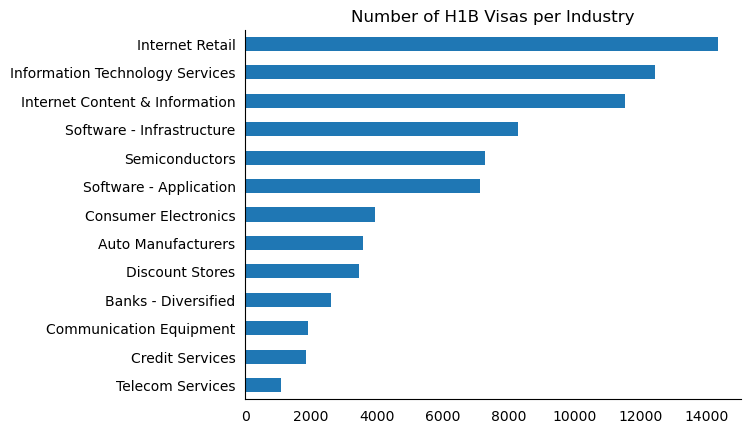

In [25]:
#Plotting the visas per industry for better understanding of where immigrant labor goes
visa_and_info_df.groupby('industry').sum()['tot_app'].loc[lambda x: x > 1000].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.ylabel("")
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.title("Number of H1B Visas per Industry")
#plt.bar(visa_and_info_df.groupby('industry').sum()['tot_app'])

Text(0.5, 1.0, 'Number of H1B Visas per Sector')

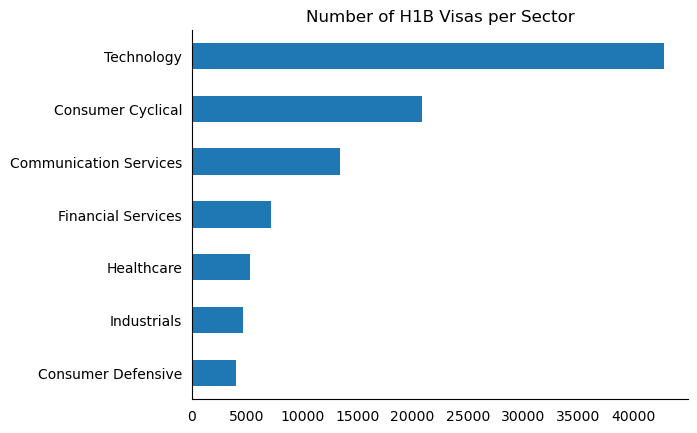

In [26]:
#Plotting sectors of H1B employees to understand immigrant work patters
visa_and_info_df.groupby('sector').sum()['tot_app'].loc[lambda x: x > 1000].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.ylabel("")
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.title("Number of H1B Visas per Sector")

Text(0.5, 1.0, 'Number of H1B Visas per City')

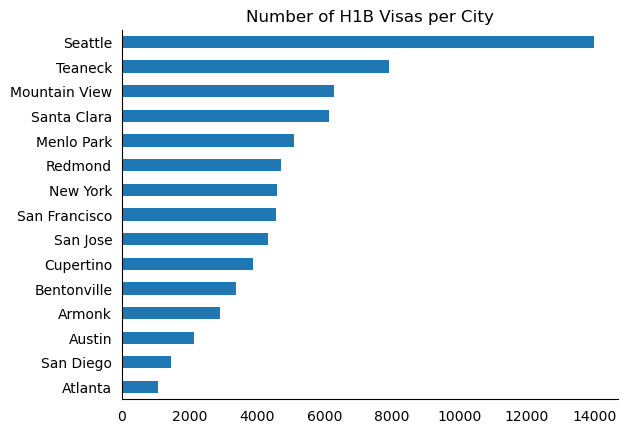

In [27]:
#Creating a city chart to support the geopandas map we use
visa_and_info_df.groupby('city').sum()['tot_app'].loc[lambda x: x > 1000].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.ylabel("")
plt.title("Number of H1B Visas per City")

Text(0.5, 1.0, 'Number of H1B Visas per State')

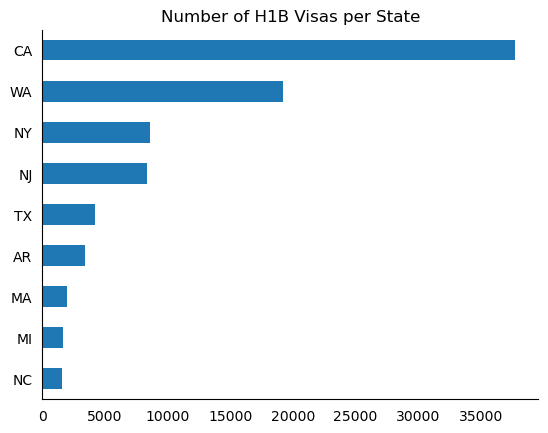

In [28]:
#Plotting the state information of the h1b visas to support the geopandas map
visa_and_info_df.groupby('state').sum()['tot_app'].loc[lambda x: x > 1500].sort_values(ascending=True).plot(kind='barh')
sns.despine()
plt.tick_params(axis='x', which='both', bottom=False, top=False) 
plt.tick_params(axis='y', which='both', left=False)
plt.ylabel("")
plt.title("Number of H1B Visas per State")

In [29]:
#We noticed extreme outliers in the data and decided that IQR isolation was the best way to handle them and to keep the main patterns of the data
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

    return df

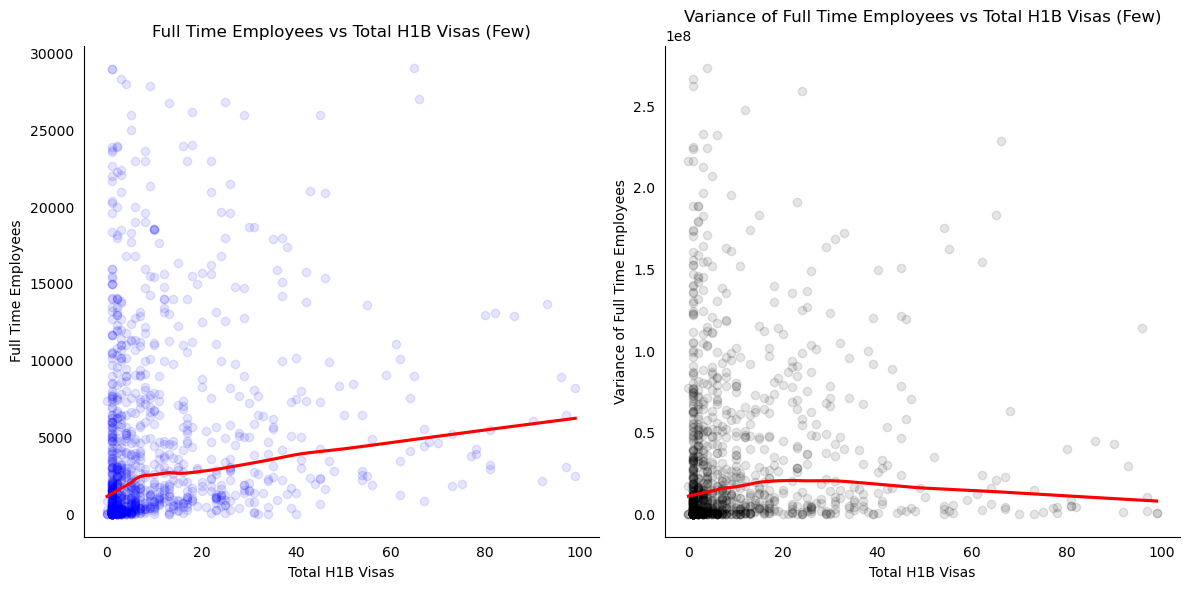

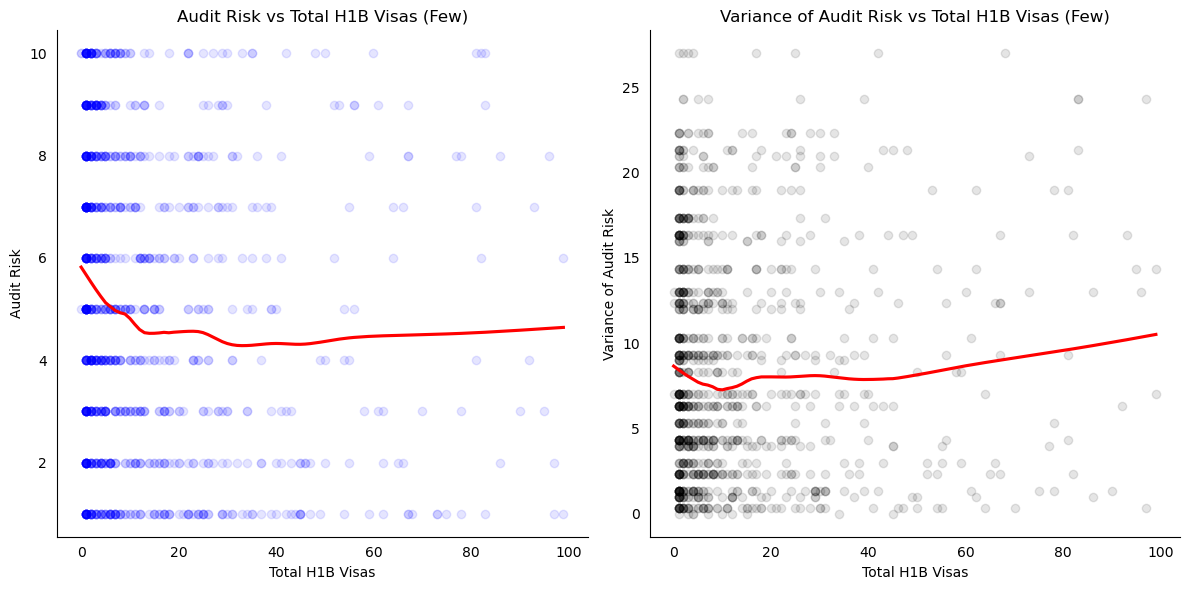

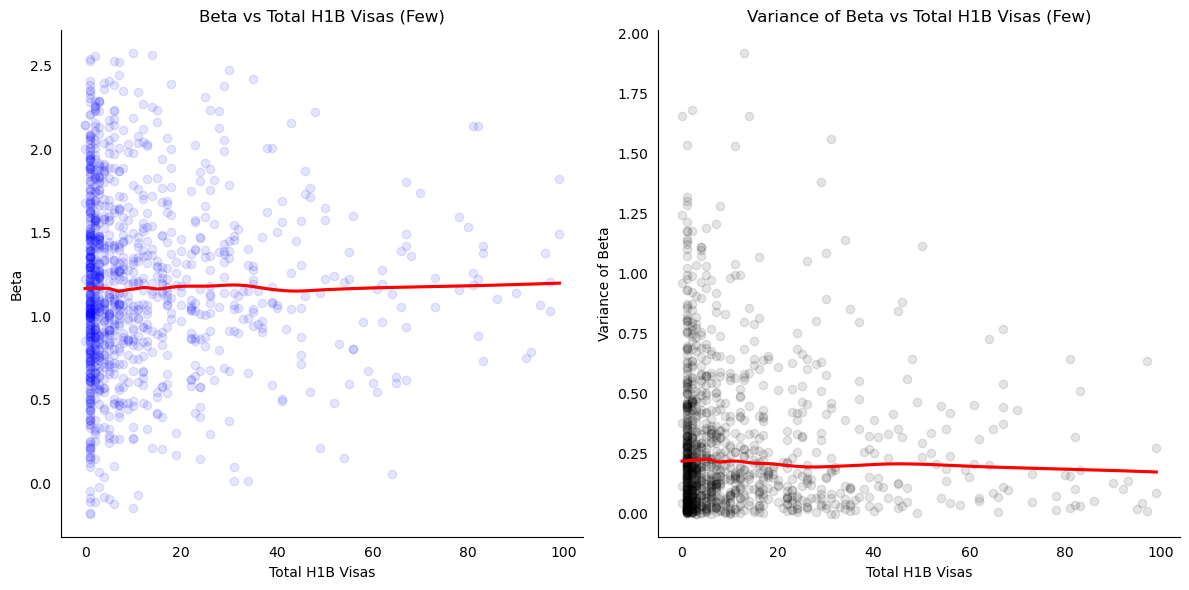

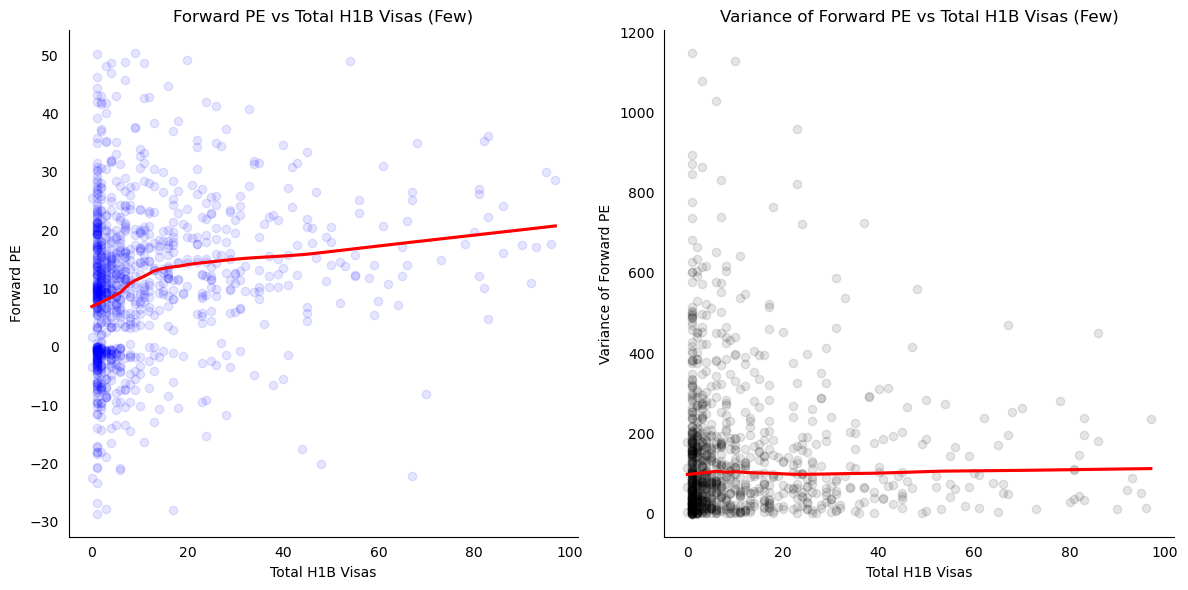

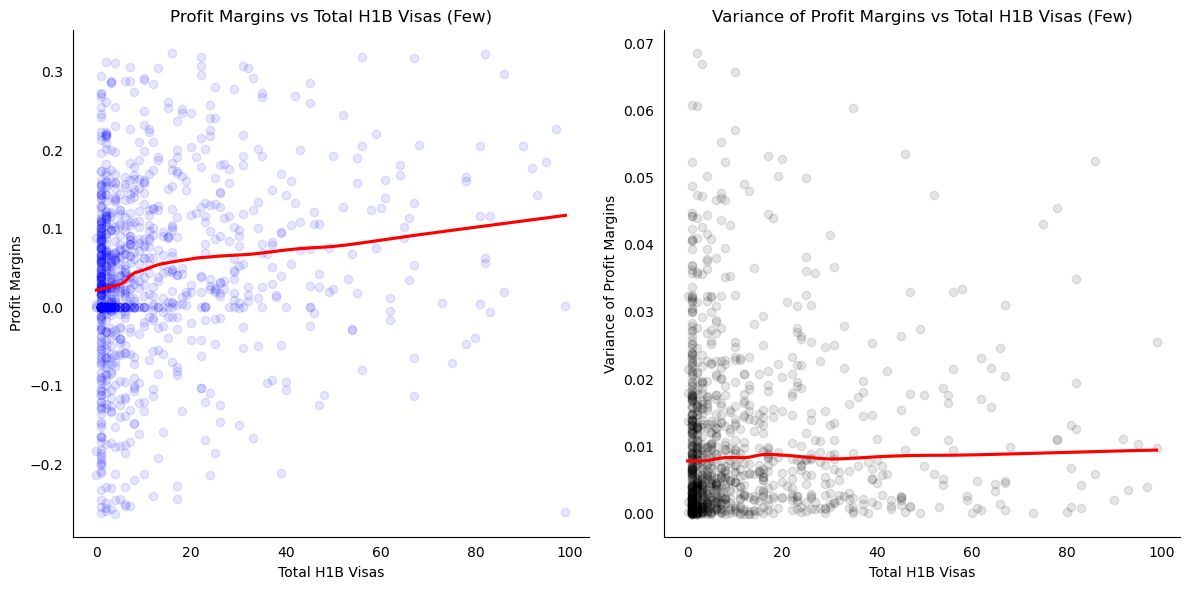

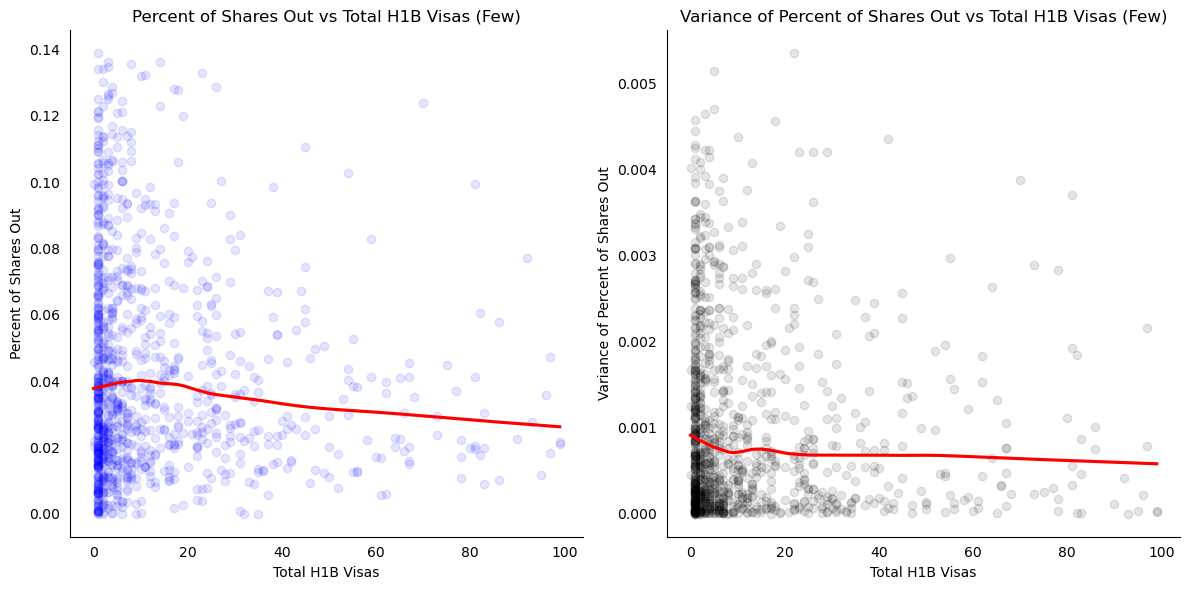

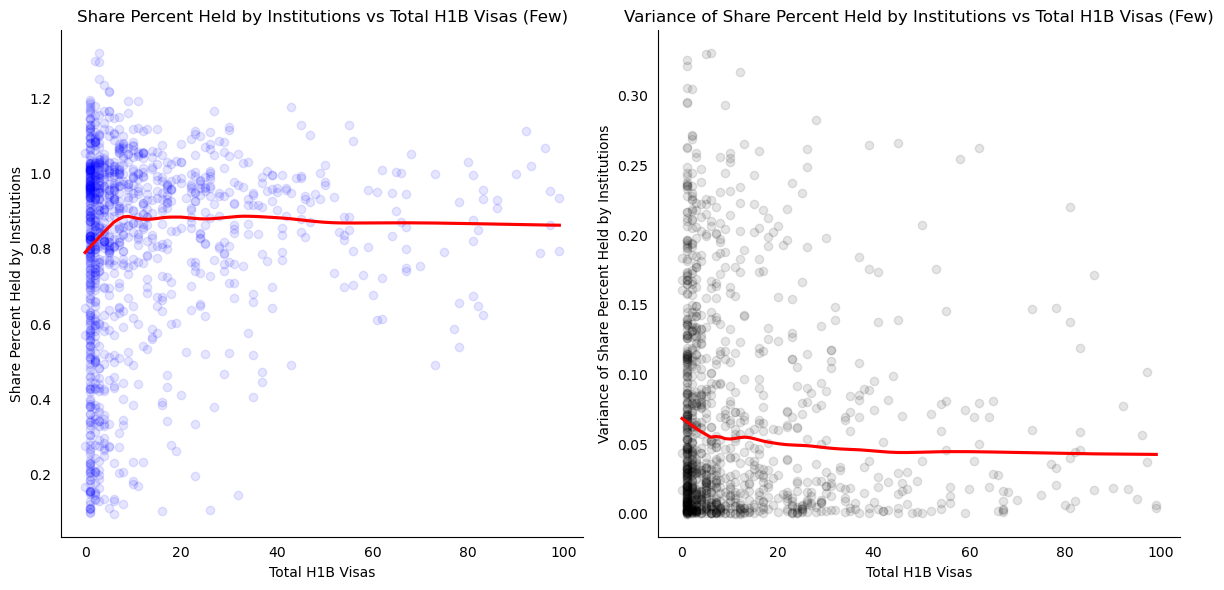

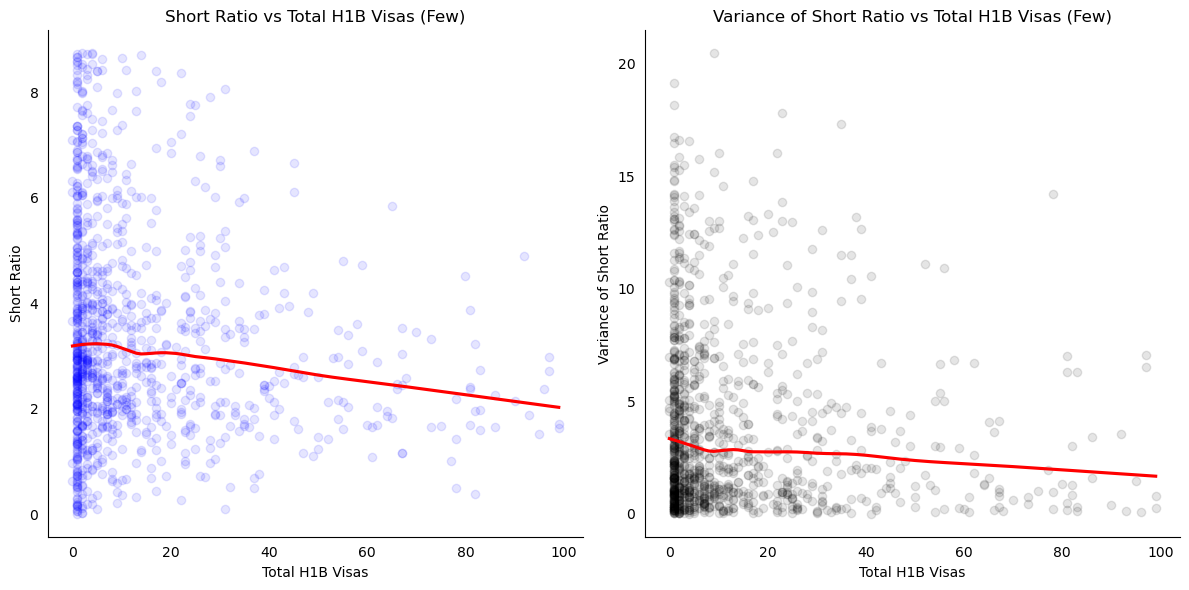

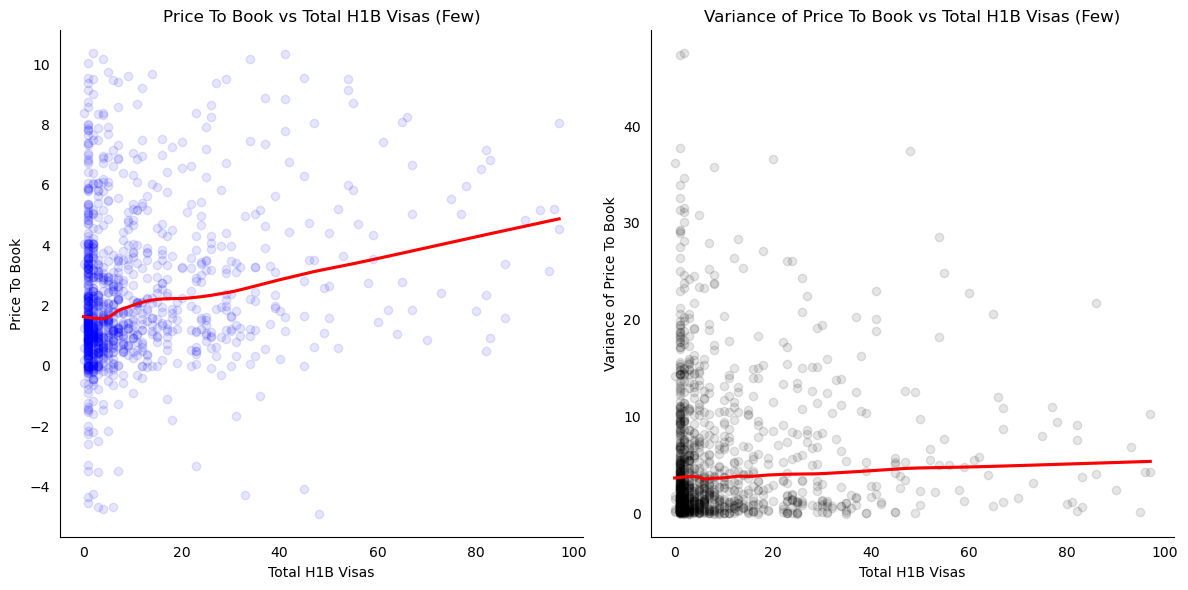

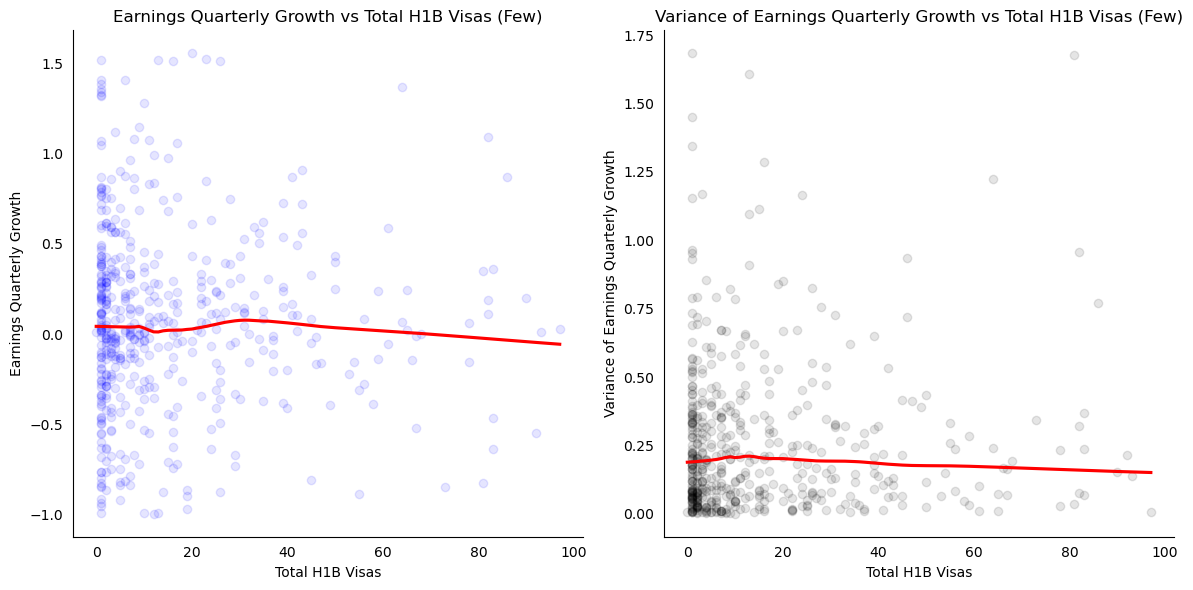

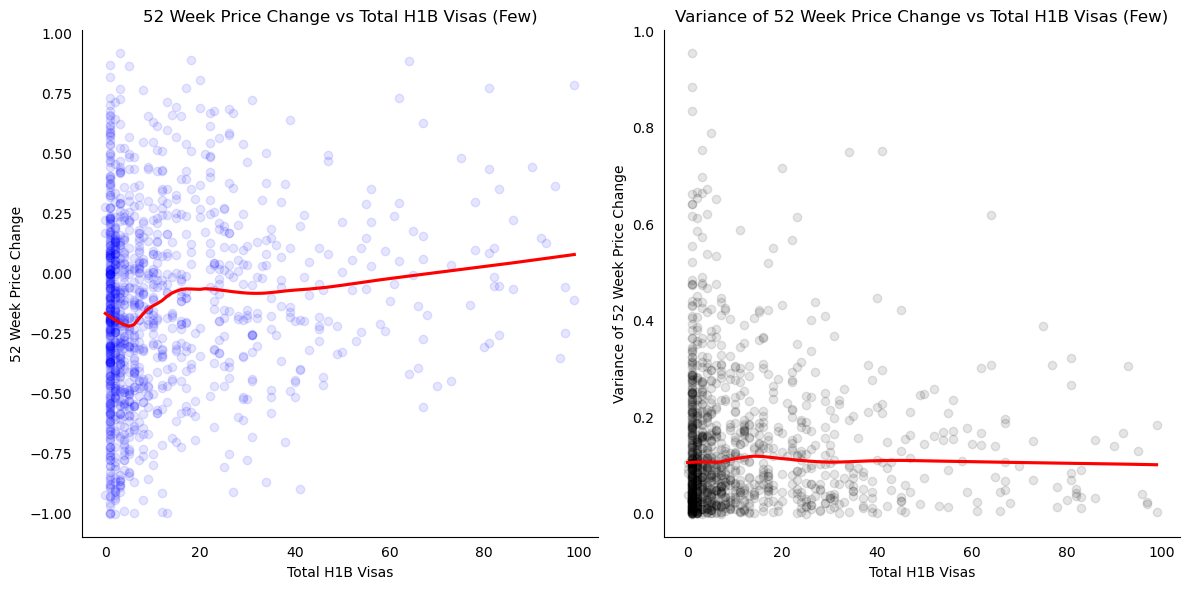

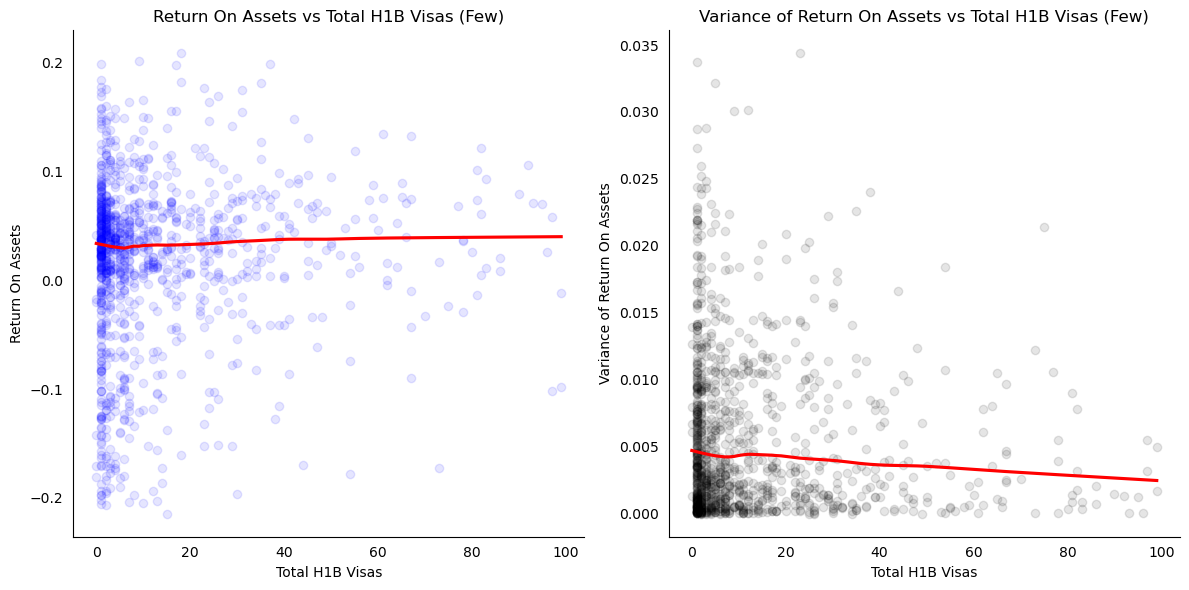

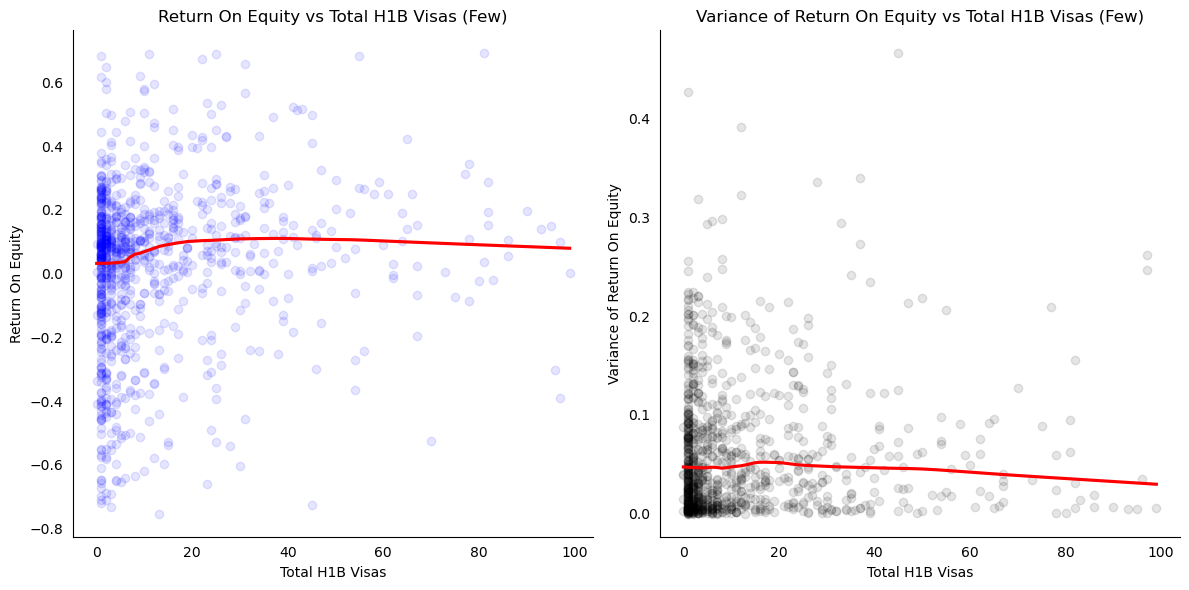

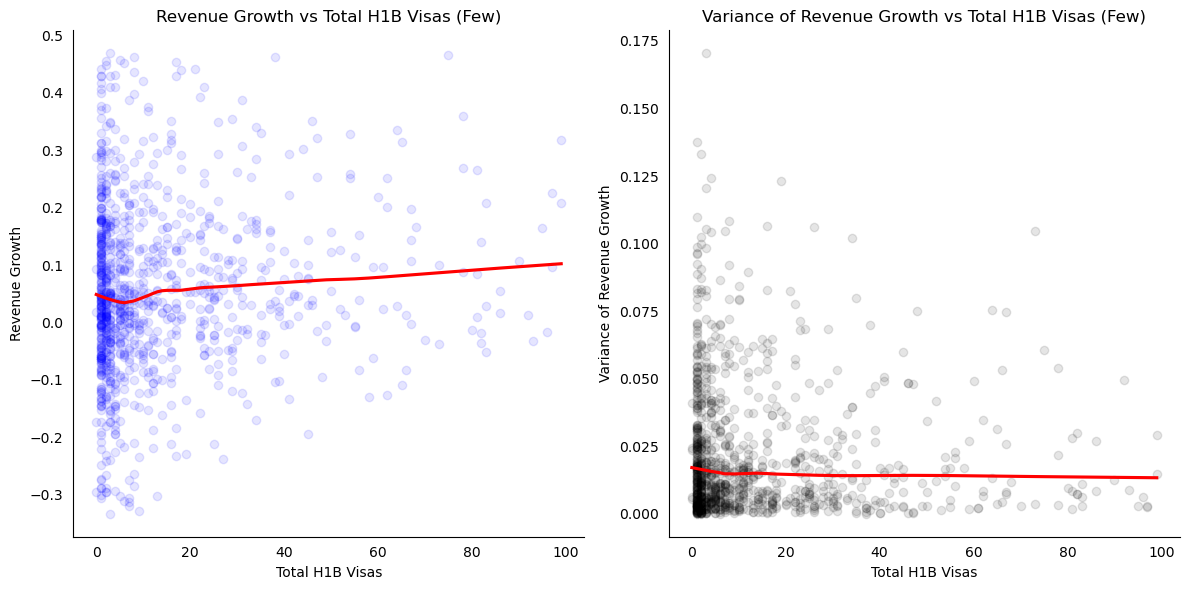

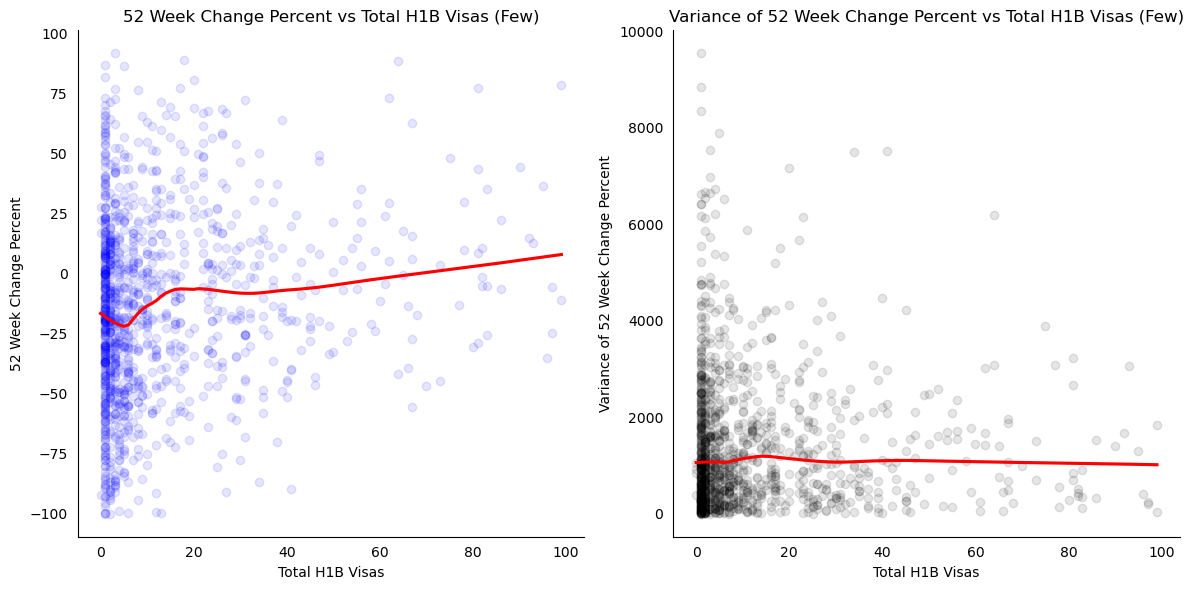

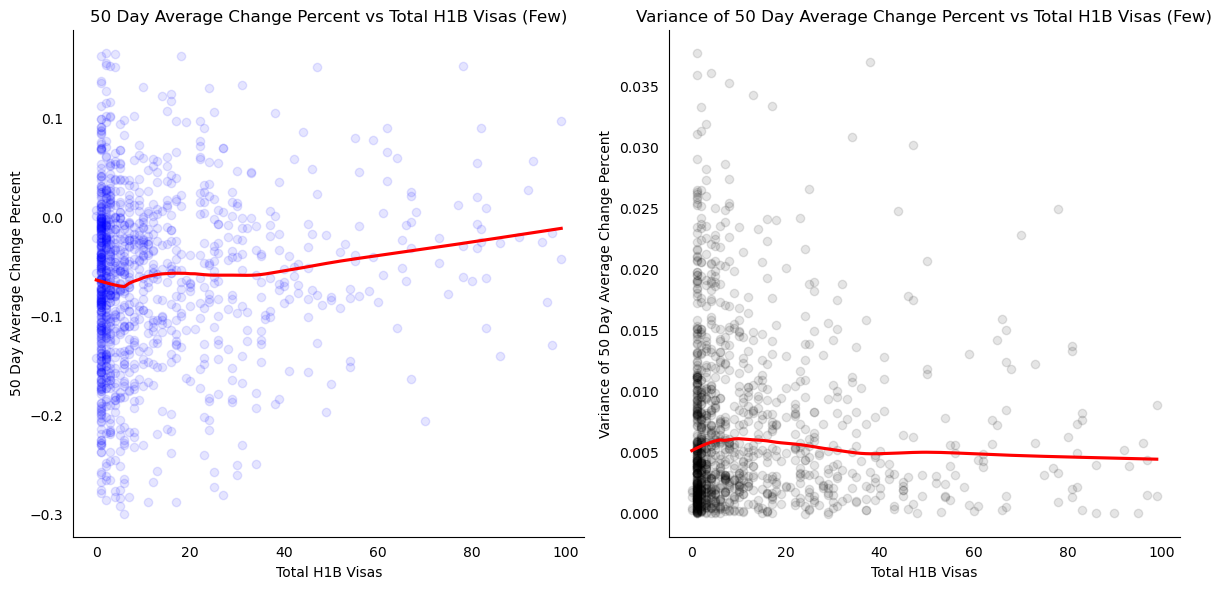

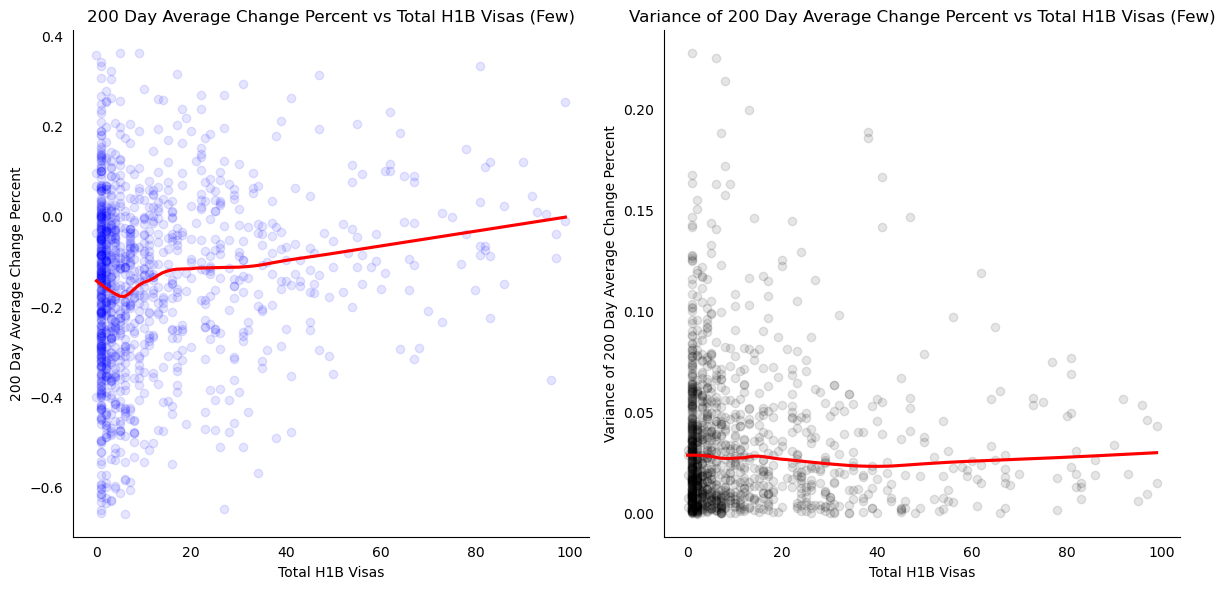

In [30]:
#These charts plot the financial indicators and variance of indicators for companies with their h1b visa counts on the x axis
#We isolated the plot variable list to these factors since these ones showed the strongest patterns and had a reasonable amount of datapoints
target_col = 'tot_app'
graphs_with_patterns = ['fullTimeEmployees', 'auditRisk', 'beta', 'forwardPE', 'profitMargins', 'sharesPercentSharesOut', 
                        'heldPercentInstitutions', 'shortRatio', 'priceToBook', 'earningsQuarterlyGrowth', '52WeekChange', 
                        'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 'fiftyTwoWeekChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent']
pretty_titles = ['Full Time Employees', 'Audit Risk', 'Beta', 'Forward PE', 'Profit Margins', 'Percent of Shares Out', 
                        'Share Percent Held by Institutions', 'Short Ratio', 'Price To Book', 'Earnings Quarterly Growth', '52 Week Price Change', 
                        'Return On Assets', 'Return On Equity', 'Revenue Growth', '52 Week Change Percent', '50 Day Average Change Percent', '200 Day Average Change Percent']

for n in range(17):
        col = graphs_with_patterns[n]
        if  col!= target_col:
            #Removing outliers to simplify the plots
            data = remove_outliers_iqr(visa_and_info_df, col)
            #Sorting plot data based on our few/many split condition
            few_visas = data[data['tot_app'] <= 100]
            many_visas = data[data['tot_app'] > 100]

            fig, axs = plt.subplots(1, 2, figsize=(12, 6))

            sns.regplot(x=few_visas[target_col], y=few_visas[col], ax=axs[0], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'blue'}, line_kws={'color': 'red'})
            axs[0].set_title(f'{pretty_titles[n]} vs Total H1B Visas (Few)')
            axs[0].set_xlabel('Total H1B Visas')
            axs[0].set_ylabel(pretty_titles[n])
            axs[0].tick_params(axis='x', which='both', bottom=False, top=False) 
            axs[0].tick_params(axis='y', which='both', left=False)

            sns.regplot(x=few_visas[target_col], y=few_visas[col].rolling(window=3).var(), ax=axs[1], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'black'}, line_kws={'color': 'red'})
            axs[1].set_title(f'Variance of {pretty_titles[n]} vs Total H1B Visas (Few)')
            axs[1].set_ylabel(f'Variance of {pretty_titles[n]}')
            axs[1].set_xlabel('Total H1B Visas')
            axs[1].tick_params(axis='x', which='both', bottom=False, top=False) 
            axs[1].tick_params(axis='y', which='both', left=False)

            plt.tick_params(axis='x', which='both', bottom=False, top=False) 
            plt.tick_params(axis='y', which='both', left=False)
            sns.despine()
            plt.tight_layout()
            plt.show()

In [31]:
#Commented out due to length of output
#Did not use any resulting graphs since they did not provide logical insight
#for n in range(17):
#        col = graphs_with_patterns[n]
#        if col != target_col:
#            print(col)
#            data = remove_outliers_iqr(visa_and_info_df, col)
#            few_visas = data[data['tot_app'] <= 100]
#            many_visas = data[data['tot_app'] > 100]
#
#            fig, axs = plt.subplots(2, 1, figsize=(10, 8))
#
#            sns.regplot(x=many_visas[target_col], y=many_visas[col], ax=axs[0], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'blue'}, line_kws={'color': 'red'})
#            axs[0].set_title(f'{pretty_titles[n]} vs Total H1B Visas (Many)')
#            axs[0].set_xlabel('Total H1B Visas')
#            axs[0].set_ylabel(pretty_titles[n])
#            axs[0].tick_params(axis='x', which='both', bottom=False, top=False) 
#            axs[0].tick_params(axis='y', which='both', left=False)
#
#            sns.regplot(x=many_visas[target_col], y=many_visas[col].rolling(window=3).var(), ax=axs[1], scatter=True, lowess=True, scatter_kws={'alpha': 0.1, 'color': 'black'}, line_kws={'color': 'red'})
#            axs[1].set_title(f'Variance of {pretty_titles[n]} vs Total H1B Visas (Many)')
#            axs[1].set_ylabel(f'Variance of {pretty_titles[n]}')
#            axs[1].set_xlabel('Total H1B Visas')
#            axs[1].tick_params(axis='x', which='both', bottom=False, top=False) 
#            axs[1].tick_params(axis='y', which='both', left=False)
#
#            plt.tick_params(axis='x', which='both', bottom=False, top=False) 
#            plt.tick_params(axis='y', which='both', left=False)
#            sns.despine()
#            plt.tight_layout()
#            plt.show()

In [32]:
with open('data/company_tickers.json', 'r') as f:
    data = json.load(f)
    
companies = [entry["ticker"] for entry in data.values()]
no_visas = []

for c in companies:
    if c not in visa_and_info_df['symbol'].values:
        no_visas.append(c)

In [35]:
# No longer using this code, it was implemented so we only had to make a small download before we had time to run a long yFinance data pull
import random
random.seed(10)
sampled_no_visas = random.sample(no_visas, 1574)

no_visa_info = fetch_stock_info(sampled_no_visas)
no_visa_info.to_csv("no_visa_info.csv")

Error downloading CJJD: list index out of range


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/ROIC?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=ROIC&crumb=S1MudHMylEz


Error downloading ROIC: 'NoneType' object has no attribute 'update'


404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WAVSW?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WAVSW&crumb=S1MudHMylEz


Error downloading WAVSW: 'NoneType' object has no attribute 'update'
Error downloading BUCRF: list index out of range
Error downloading SGLDF: list index out of range
Error downloading KNRX: list index out of range
Error downloading FFIEW: list index out of range
Error downloading IVAC: list index out of range
Error downloading GLACR: list index out of range
Error downloading CLRCU: list index out of range
Error downloading PGDED: list index out of range
Error downloading CSSI: list index out of range
Error downloading CRGT: list index out of range


KeyboardInterrupt: 

In [34]:
no_visa_info_df = pd.read_csv('no_visa_info.csv').T
no_visa_info_df = no_visa_info_df.rename(columns=no_visa_info_df.iloc[0]).drop(no_visa_info_df.index[0]).reset_index()
no_visa_info_df['visa'] = 0

FileNotFoundError: [Errno 2] No such file or directory: 'no_visa_info.csv'

In [ ]:
company_info_df['visa'] = 1
company_info_df.rename(columns={'Unnamed: 0': 'index'}, inplace=True)

In [ ]:
dummy_visas = pd.concat([no_visa_info_df, company_info_df])
dummy_visas.set_index(dummy_visas.columns[0], inplace=True)
dummy_visas.head()
#This df has an indicator variable if the company offers visas or not

address1  \
index                                   
JAGX                  200 Pine Street   
RKT              1050 Woodward Avenue   
SRTS      851 Broken Sound Parkway NW   
ANGH   Al-Khatem Tower, WeWork Hub 71   
EVGN          13 Gad Feinstein Street   

                                                address2           city state  \
index                                                                           
JAGX                                           Suite 400  San Francisco    CA   
RKT                                                  NaN        Detroit    MI   
SRTS                                           Suite 215     Boca Raton    FL   
ANGH   16th Floor Abu Dhabi Global Market Square Al M...      Abu Dhabi   NaN   
EVGN                                        Park Rehovot        Rehovot   NaN   

           zip               country           phone  \
index                                                  
JAGX     94104         United States    415 371 8300   
RKT      48226         United States    313 373 7990   
SRTS     33487         United States    561 922 5808   
ANGH       NaN  United Arab Emirates             NaN   
EVGN   7638517                Israel  972 8 931 1900   

                               website          industry       industryKey  \
index                                                                        
JAGX             https://jaguar.health     Biotechnology     biotechnology   
RKT    https://www.rocketcompanies.com  Mortgage Finance  mortgage-finance   
SRTS      https://sensushealthcare.com   Medical Devices   medical-devices   
ANGH           https://www.anghami.com     Entertainment     entertainment   
EVGN           https://www.evogene.com     Biotechnology     biotechnology   

       ... netAssets netExpenseRatio postMarketTime postMarketChangePercent  \
index  ...                                                                    
JAGX   ...       NaN             NaN            NaN                     NaN   
RKT    ...       NaN             NaN            NaN                     NaN   
SRTS   ...       NaN             NaN            NaN                     NaN   
ANGH   ...       NaN             NaN            NaN                     NaN   
EVGN   ...       NaN             NaN            NaN                     NaN   

      postMarketPrice postMarketChange prevExchange exchangeTransferDate  \
index                                                                      
JAGX              NaN              NaN          NaN                  NaN   
RKT               NaN              NaN          NaN                  NaN   
SRTS              NaN              NaN          NaN                  NaN   
ANGH              NaN              NaN          NaN                  NaN   
EVGN              NaN              NaN          NaN                  NaN   

      newListingDate visa  
index                      
JAGX             NaN    0  
RKT              NaN    0  
SRTS             NaN    0  
ANGH             NaN    0  
EVGN             NaN    0  

[5 rows x 204 columns]

In [ ]:
import numpy as np
dv_numerical = dummy_visas[dummy_visas['country'] == 'United States']#.select_dtypes(include=[np.number])
#Removing non-US companies since they are not in the USCIS pool

In [ ]:
keep_cols = ['fullTimeEmployees', 'auditRisk', 'beta', 'forwardPE', 'profitMargins', 'sharesPercentSharesOut', 
                        'heldPercentInstitutions', 'shortRatio', 'priceToBook', 'earningsQuarterlyGrowth', '52WeekChange', 
                        'returnOnAssets', 'returnOnEquity', 'revenueGrowth', 'fiftyTwoWeekChangePercent', 'fiftyDayAverageChangePercent', 'twoHundredDayAverageChangePercent', 'visa']
dv_numericals = dv_numerical[keep_cols]


In [ ]:
dv_numericals = dv_numericals.loc[:, ~dv_numericals.columns.duplicated()].astype(float)
dv_numericals.head()

fullTimeEmployees  auditRisk   beta  forwardPE  profitMargins  \
index                                                                  
JAGX                49.0        NaN  1.115  -4.055556        0.00000   
RKT              14200.0        3.0  2.356  19.378788        0.00542   
SRTS                54.0        NaN  1.115   8.146552        0.15899   
FCX              28500.0        6.0  1.708  17.268517        0.07111   
AMAL               429.0        2.0  0.743   8.011494        0.34981   

       sharesPercentSharesOut  heldPercentInstitutions  shortRatio  \
index                                                                
JAGX                   0.0778                  0.01665        1.44   
RKT                    0.1744                  0.74550        2.60   
SRTS                   0.0508                  0.30152        6.71   
FCX                    0.0194                  0.85644        1.49   
AMAL                   0.0511                  0.64978        5.69   

       priceToBook  earningsQuarterlyGrowth  52WeekChange  returnOnAssets  \
index                                                                       
JAGX      0.767808                      NaN     -0.970148        -0.36990   
RKT       2.658491                      NaN      0.065587         0.03250   
SRTS      3.017241                    4.224      0.372434         0.08727   
FCX       2.952351                   -0.256     -0.254851         0.07496   
AMAL      1.208391                    0.079      0.126423         0.01312   

       returnOnEquity  revenueGrowth  fiftyTwoWeekChangePercent  \
index                                                             
JAGX         -5.65739          0.526                 -97.014820   
RKT           0.07332          1.505                   6.558704   
SRTS          0.12701          1.557                  37.243400   
FCX           0.14062         -0.094                 -25.485146   
AMAL          0.16463          0.017                  12.642277   

       fiftyDayAverageChangePercent  twoHundredDayAverageChangePercent  visa  
index                                                                         
JAGX                      -0.008228                          -0.603698   0.0  
RKT                       -0.048632                          -0.147626   0.0  
SRTS                      -0.017467                          -0.250006   0.0  
FCX                        0.014867                          -0.107970   0.0  
AMAL                      -0.062845                          -0.132484   0.0

In [ ]:
group_means = dv_numericals.groupby('visa').mean()

In [ ]:
group_means.index = ['No H1B Employees', 'H1B Employees']
colors = ['blue', 'orange'] 
#This code is commented out due to output length and no statistical significance was found with the difference of means
#for col in group_means.columns:
#    group_means[col].plot(kind='bar', title=col, color=colors)
#    plt.ylabel('Mean Value')
#    sns.despine()
#    plt.xticks(rotation = 0)
#    plt.show()


In [ ]:
group_medians = dv_numericals.groupby('visa').median()

In [ ]:
group_medians.index = ['No H1B Employees', 'H1B Employees']
#for col in group_medians.columns:
#    group_medians[col].plot(kind='bar', title=col, color=colors)
#    plt.ylabel('Median Value')
#    sns.despine()
#    plt.xticks(rotation = 0)
#    plt.show()

In [ ]:
group_stds = dv_numericals.groupby('visa').std()
group_stds.index = ['No H1B Employees', 'H1B Employees']
#for col in group_medians.columns:
#    group_medians[col].plot(kind='bar', title=col, color=colors)
#    plt.ylabel('Standard Deviation')
#    sns.despine()
#    plt.xticks(rotation = 0)
#    plt.show()

In [ ]:
import scipy.stats as stats
#Implemented from https://www.geeksforgeeks.org/scipy-statistical-significance-tests/
def check_significance(sample1, sample2, alpha=0.1):
    t_stat, p_value = stats.ttest_ind(sample1, sample2, equal_var=False) 
    if p_value < alpha:
        return f"Statistically significant (p = {p_value:.4f})", p_value
    else:
        return f"Not statistically significant (p = {p_value:.4f})", p_value



In [ ]:
#Commented due to the length of the print on github
#Made to test if there were statistically significant differences of the means of multiple variables
for x in dv_numericals.columns:
    if x != 'visa':
        result, p_value = check_significance(dv_numericals[dv_numericals['visa']==0][x], dv_numericals[dv_numericals['visa']==1][x])
        #print(x)
        #print(result)
        #print()


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
#Commented due to the length of the print
#Made to look for insights of the related variables
#for x in dv_numericals.columns:
#    if x != 'visa':
#        try:
#            print(x)
#            print(smf.ols('visa ~ '+x, data=dv_numericals).fit().summary())
#            print()
#        except:
#            print("Error with "+x)

In [ ]:
#Commented due to the length of the print
#Made to look for insights of the related variables
#for x in dv_numericals.columns:
#    for y in dv_numericals.columns:
#        if x != 'visa' and x!=y:
#            try:
#                print(x +" and "+y)
#                print(smf.ols('visa ~ '+x+' + '+y, data=dv_numericals).fit().summary())
#                print()
#            except:
#                print("Error with ")

In [ ]:
#Commented due to the length of the print
#Made to look for insights of the related variables
#print(smf.ols('visa ~ '+" + ".join(col for col in dv_numericals.columns if col != 'visa' and col != '52WeekChange'), data=dv_numericals).fit().summary())

In [ ]:
#fetch_stock_data(dv_numericals.index)

In [ ]:
price_df = pd.read_csv('sp500_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'sp500_data.csv'

In [ ]:
test_df = price_df.T
test_df.head()

0       1     2           3           4           5     \
Unnamed: 0  Price  Ticker  Date  2020-01-02  2020-01-03  2020-01-06   
JAGX        Close    JAGX   NaN    265612.5    251775.0    258862.5   
JAGX.1       High    JAGX   NaN    324000.0    256500.0    259875.0   
JAGX.2        Low    JAGX   NaN    249750.0    226125.0    242325.0   
JAGX.3       Open    JAGX   NaN    294300.0    236587.5    256500.0   

                  6           7           8           9     ...        1300  \
Unnamed: 0  2020-01-07  2020-01-08  2020-01-09  2020-01-10  ...  2025-03-03   
JAGX          267300.0    273375.0    267637.5    255825.0  ...        14.4   
JAGX.1        312187.5    293625.0    279787.5    273375.0  ...       15.75   
JAGX.2        259875.0    259875.0    264937.5    253125.0  ...       13.75   
JAGX.3        266625.0    286875.0    270000.0    271012.5  ...        15.5   

                  1301        1302        1303        1304        1305  \
Unnamed: 0  2025-03-04  2025-03-05  2025-03-06  2025-03-07  2025-03-10   
JAGX             14.25      14.775      14.475      14.425      13.675   
JAGX.1            14.4        15.0      15.125       14.75       15.05   
JAGX.2           13.75      14.275        14.0       13.95        13.2   
JAGX.3           14.25      14.275        15.0      14.125        14.5   

                  1306        1307        1308        1309  
Unnamed: 0  2025-03-11  2025-03-12  2025-03-13  2025-03-14  
JAGX            11.925        12.0      11.225      11.125  
JAGX.1           13.75        13.0      12.425      11.375  
JAGX.2           11.75        11.5        11.0      10.525  
JAGX.3           13.75        13.0      11.775       11.25  

[5 rows x 1310 columns]

In [ ]:
filtered_df = test_df[~test_df.index.str.contains(r'\d')].T
filtered_df.columns = filtered_df.iloc[1]
filtered_df.iloc[3:].astype(float).to_csv('clean_prices.csv')

In [ ]:
filtered_df = pd.read_csv('clean_prices.csv').drop(columns='Unnamed: 0')
filtered_df.head()

JAGX  RKT  SRTS        FCX       AMAL  NEUE  PLMKW   CLFD  RANGR  \
0  265612.5  NaN  3.69  12.393362  17.358105   NaN    NaN  13.93    NaN   
1  251775.0  NaN  3.67  12.017806  17.294981   NaN    NaN  13.73    NaN   
2  258862.5  NaN  3.68  12.064751  17.033484   NaN    NaN  13.84    NaN   
3  267300.0  NaN  3.60  12.252529  16.808052   NaN    NaN  13.87    NaN   
4  273375.0  NaN  3.57  12.374583  17.132671   NaN    NaN  13.83    NaN   

        LGIH  ...        UDR       VANI  VERA       VSEC  WGSWW        WKC  \
0  70.620003  ...  37.553368  17.688000   NaN  35.924297    NaN  38.833096   
1  71.059998  ...  37.854645  16.200001   NaN  36.096508    NaN  38.401508   
2  72.279999  ...  37.773212  15.630000   NaN  36.249573    NaN  37.871040   
3  74.769997  ...  37.309090  14.190000   NaN  35.579887    NaN  37.520390   
4  75.790001  ...  37.357948  14.520000   NaN  35.225903    NaN  37.421478   

   WS        WT       WTRG   ZVRA  
0 NaN  4.217573  39.914036  6.480  
1 NaN  4.109890  40.201111  6.560  
2 NaN  4.091943  40.061928  6.928  
3 NaN  3.975286  40.296825  8.640  
4 NaN  3.939392  40.462109  8.192  

[5 rows x 3084 columns]

In [ ]:
filtered_df = filtered_df.loc[:, ((filtered_df < 10000) & (filtered_df >= 1)).all()]

In [ ]:
no_visa_tickers = dv_numericals[dv_numericals['visa'] == 0].index
visa_tickers = dv_numericals[dv_numericals['visa'] == 1].index
few_visas = visa_and_info_df[visa_and_info_df['tot_app'] < 100]['Unnamed: 0']
many_visas = visa_and_info_df[visa_and_info_df['tot_app'] >= 100]['Unnamed: 0']


C:\Users\owenh\AppData\Local\Temp\ipykernel_41380\1687757354.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\owenh\anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


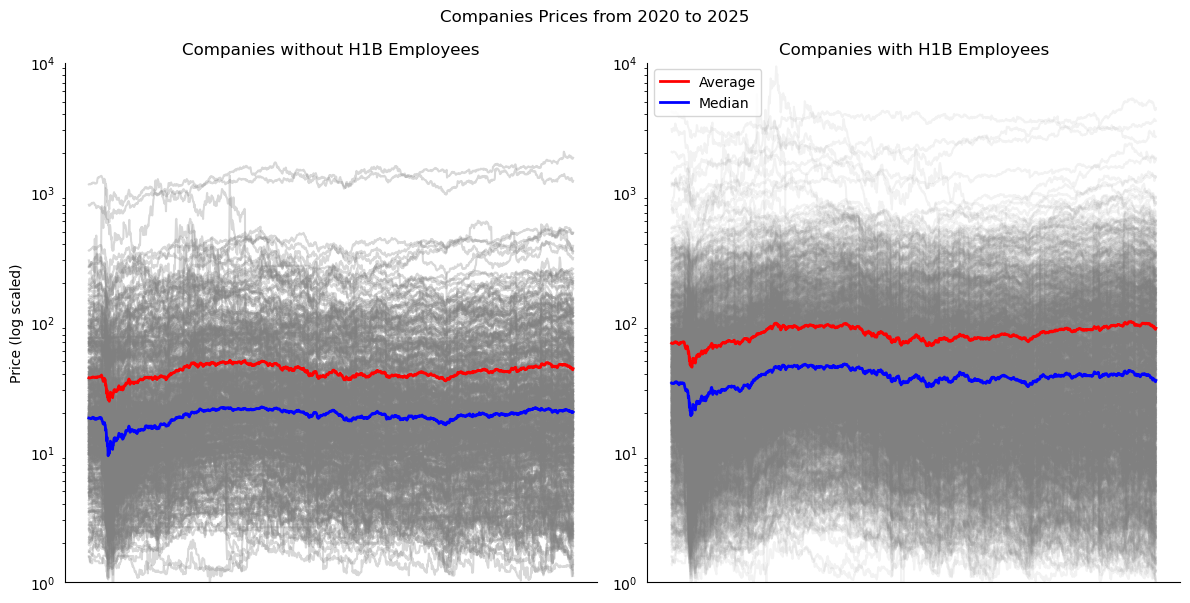

In [ ]:
#Plotting all stock prices in a shadow plot style with average and medians for interpretation
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
avg_ticks = []
for ticker in no_visa_tickers:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        axs[0].plot(filtered_df[ticker], color = 'gray', alpha = .3)

#Plotting an average and median trend line for ease of graphical interpretation
avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
axs[0].plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
axs[0].plot(med_line, color='blue', label='Median', linewidth=2)

axs[0].set_yscale('log')
axs[0].set_ylabel("Price (log scaled)")
axs[0].tick_params(left=False, bottom=False, labelbottom=False)
axs[0].set_title('Companies without H1B Employees')

avg_ticks= []
for ticker in visa_tickers:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        axs[1].plot(filtered_df[ticker], color = 'gray', alpha = .1)

avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
axs[1].plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
axs[1].plot(med_line, color='blue', label='Median', linewidth=2)

axs[1].tick_params(left=False, bottom=False, labelbottom=False)
axs[1].set_yscale('log')
axs[1].set_title('Companies with H1B Employees')

#Cleaning up graph styles
fig.suptitle("Companies Prices from 2020 to 2025")
plt.legend()
plt.tight_layout()
sns.despine()

axs[0].set_ylim([1, 10000])
axs[1].set_ylim([1, 10000])
plt.show()

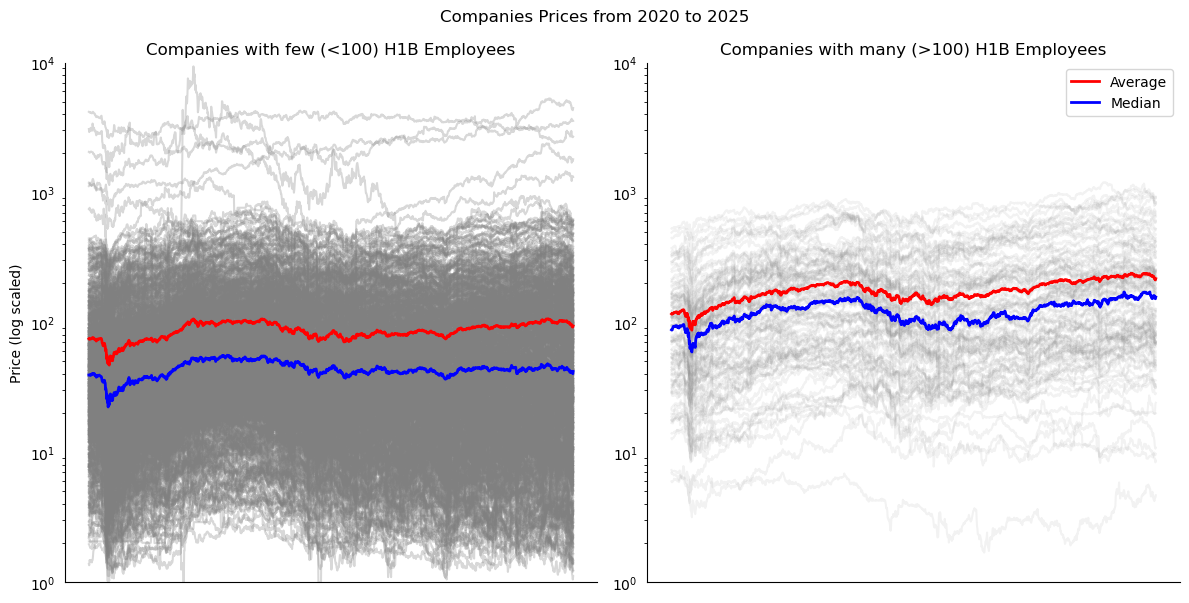

In [ ]:
#Plotting all stock prices with visas in a shadow plot style with average and medians for interpretation
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
avg_ticks = []
for ticker in few_visas:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        axs[0].plot(filtered_df[ticker], color = 'gray', alpha = .3)

#Mean and median plots
avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
axs[0].plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
axs[0].plot(med_line, color='blue', label='Median', linewidth=2)

axs[0].set_yscale('log')
axs[0].set_ylabel("Price (log scaled)")
axs[0].tick_params(left=False, bottom=False, labelbottom=False)
axs[0].set_title('Companies with few (<100) H1B Employees')

avg_ticks= []
for ticker in many_visas:
    if ticker in filtered_df.columns:
        avg_ticks.append(ticker)
        axs[1].plot(filtered_df[ticker], color = 'gray', alpha = .1)

avg_line = filtered_df[avg_ticks].mean(axis=1, skipna=True)
axs[1].plot(avg_line, color='red', label='Average', linewidth=2)

med_line = filtered_df[avg_ticks].median(axis=1, skipna=True)
axs[1].plot(med_line, color='blue', label='Median', linewidth=2)

axs[1].tick_params(left=False, bottom=False, labelbottom=False)
axs[1].set_yscale('log')
axs[1].set_title('Companies with many (>100) H1B Employees')

#Cleaning up graphs
fig.suptitle("Companies Prices from 2020 to 2025")
plt.legend()
plt.tight_layout()
sns.despine()

axs[0].set_ylim([1, 10000])
axs[1].set_ylim([1, 10000])
plt.show()